In [75]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.optimize import curve_fit
import seaborn as sns

In [76]:
plt.style.use("default")
sns.set_theme(
    context="paper",
    style="white",
    palette="tab10",
    font="serif",
    font_scale=1.5,
    color_codes=True,
    rc={"text.usetex": True},
)
os.makedirs("../figures/SCALING/", exist_ok=True)
fig_dir = "../figures/SCALING/"

In [77]:
def load_experiment_data(root_dir: str, lr: float = 0.001) -> pd.DataFrame:
    """Load experiment data from complex directory structure"""
    records = []
    root_path = Path(root_dir)

    # Find all terminal seed directories containing results
    for seed_dir in root_path.glob("**/seed=*/"):
        # Extract parameters from path components
        params = {
            "hidden_size": None,
            "dataset_size": None,
            "lr": None,
            "n_classes": None,
            "seed": int(seed_dir.name.split("=")[1]),
        }

        # Parse parameters from parent directories
        for parent in seed_dir.parents:
            if parent.name.startswith("hidden_size="):
                params["hidden_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("dataset_size="):
                params["dataset_size"] = int(parent.name.split("=")[1])
            elif parent.name.startswith("lr="):
                params["lr"] = float(parent.name.split("=")[1])
            elif parent.name.startswith("n_classes="):
                params["n_classes"] = int(parent.name.split("=")[1])

        # Validate all parameters found
        if None in params.values():
            missing = [k for k, v in params.items() if v is None]
            print(f"Skipping {seed_dir} - missing: {missing}")
            continue

        try:
            # Load metrics files
            test_losses = np.loadtxt(seed_dir / "test_losses.txt")
            train_losses = np.loadtxt(seed_dir / "train_losses.txt")
            control = np.loadtxt(seed_dir / "controls.txt")
            epochs = np.loadtxt(seed_dir / "epochs.txt")

            records.append(
                {
                    **params,
                    "test_loss": test_losses,
                    "train_loss": train_losses,
                    "epoch": epochs,
                    "control": control,
                }
            )
        except Exception as e:
            print(f"Error loading {seed_dir}: {str(e)}")
            continue

    return pd.DataFrame(records)

In [78]:
growing_df = load_experiment_data(
    "../output/spiral_classification/task=classification/"
)
baseline_df = load_experiment_data(
    "../output/spiral_classification_baseline/task=classification/"
)

# growing_df = load_experiment_data("../output_old/bessel_regression/")
# baseline_df = load_experiment_data("../output_old/bessel_regression_baseline/")

In [79]:
def calculate_mean_std_across_runs(df: pd.DataFrame) -> pd.DataFrame:
    """
    Calculates the mean and standard deviation of array-valued columns
    across different runs, grouping by all *scalar* columns *except* the 'seed' column.
    """

    if "seed" not in df.columns:
        raise ValueError("DataFrame must contain a 'seed' column.")

    array_cols = [col for col in df.columns if isinstance(df[col].iloc[0], np.ndarray)]

    if not array_cols:
        raise ValueError("No array-valued columns found.")

    scalar_cols = [col for col in df.columns if col != "seed" and col not in array_cols]

    def mean(x: pd.Series) -> np.ndarray:
        """Calculates the mean array across runs."""
        return np.mean(np.stack(x.values), axis=0)

    def std(x: pd.Series) -> np.ndarray:
        """Calculates the standard deviation array across runs."""
        return np.std(np.stack(x.values), axis=0)

    grouped = df.groupby(scalar_cols)

    # Calculate the mean and std for each array-valued column
    agg_dict = {col: [mean, std] for col in array_cols}
    result = grouped.agg(agg_dict)

    # Flatten the multi-level column index
    result.columns = [
        "_".join(col).strip() for col in result.columns.values
    ]  # More robust flattening

    return result

In [80]:
processed_growing = calculate_mean_std_across_runs(growing_df)
processed_baseline = calculate_mean_std_across_runs(baseline_df)

In [ ]:
lr = 3e-4
dataset_size = 2**15
n_classes = 9

In [82]:
processed_growing

test_loss_mean  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [1.4451423287391663, 1.4368685126304626, 1.428...   
                                5          [1.960696268081665, 1.9524317979812622, 1.9443...   
                                7          [2.297693943977356, 2.2893450975418093, 2.2811...   
                                9          [2.5583770751953123, 2.549582266807556, 2.5409...   
                         0.0003 3          [1.4449747562408448, 1.4207440972328187, 1.398...   
...                                                                                      ...   
1024        32768        0.0003 9          [2.5172523975372316, 2.4900712728500367, 2.396...   
                         0.0010 3          [1.4181172728538514, 1.0890464425086974, 0.952...   
                                5          [1.9290173411369325, 1.6056715369224548, 1.476...   
                                7          [2.2654674291610717, 1.9451899647712707, 1.822...   
                                9          [2.5167985200881957, 2.195809030532837, 2.0724...   

                                                                               test_loss_std  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [0.01754597111979207, 0.01666550516845924, 0.0...   
                                5          [0.01606535586864513, 0.01535415224083033, 0.0...   
                                7          [0.012489663216048736, 0.012100368453541744, 0...   
                                9          [0.007237730285193115, 0.006976088385926292, 0...   
                         0.0003 3          [0.01752829221335617, 0.014927793856406298, 0....   
...                                                                                      ...   
1024        32768        0.0003 9          [0.000198170958613454, 0.00014483784254947415,...   
                         0.0010 3          [0.00019615139638326254, 0.002828854548461236,...   
                                5          [0.0001623674990238342, 0.0034447245660645712,...   
                                7          [0.00017235409027318977, 0.0036766673309318676...   
                                9          [0.0001936011845117361, 0.002568429826213945, ...   

                                                                             train_loss_mean  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [1.4440908551216125, 1.4358585357666016, 1.427...   
                                5          [1.9585651278495788, 1.9503409624099732, 1.942...   
                                7          [2.296136999130249, 2.2878326892852785, 2.2797...   
                                9          [2.5571786403656005, 2.5484251260757445, 2.539...   
                         0.0003 3          [1.4440908551216125, 1.4199689865112304, 1.397...   
...                                                                                      ...   
1024        32768        0.0003 9          [2.5173666000366213, 2.490286350250244, 2.3974...   
                         0.0010 3          [1.4186986088752747, 1.094412136077881, 0.9528...   
                                5          [1.9295290350914, 1.610268771648407, 1.4747057...   
                                7          [2.266014742851257, 1.950521993637085, 1.82106...   
                                9          [2.5173666000366213, 2.200905990600586, 2.0721...   

                                                                              train_loss_std  \
hidden_size dataset_size lr     n_classes                                                      
4           32768        0.0001 3          [0.017300495761135123, 0.01643594478940435, 0....   
                                5          

In [83]:
single_param_growing = processed_growing[
    processed_growing.index.get_level_values("lr") == lr
]
single_param_growing = single_param_growing[
    single_param_growing.index.get_level_values("dataset_size") == dataset_size
]

single_param_growing = single_param_growing[
    single_param_growing.index.get_level_values("n_classes") == n_classes
]


In [84]:
single_param_growing.head()

,,,,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,n_classes,,,,,,,,
4,32768,0.0003,7,"[2.297525143623352, 2.272995185852051, 2.24978...","[0.012482049195968717, 0.01128539541265689, 0....","[2.296136999130249, 2.271735692024231, 2.24866...","[0.010666232847132435, 0.009587309465216404, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
8,32768,0.0003,7,"[2.282035565376282, 2.2592297315597536, 2.2375...","[0.006761011088531835, 0.00583663782949157, 0....","[2.2811111927032472, 2.2584248542785645, 2.236...","[0.005415120465368067, 0.004622168284366695, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
16,32768,0.0003,7,"[2.2741113662719727, 2.2524815082550047, 2.231...","[0.0037050670547104075, 0.0029662838791053854,...","[2.273514747619629, 2.2519944429397585, 2.2309...","[0.0027128074776929982, 0.0021241247641835166,...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
32,32768,0.0003,7,"[2.270061802864075, 2.249179244041443, 2.22755...","[0.002072042497140164, 0.0015139491097873904, ...","[2.269696593284607, 2.24890615940094, 2.227396...","[0.0013422150538407024, 0.0009430096338610977,...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."
64,32768,0.0003,7,"[2.267988395690918, 2.247487211227417, 2.22391...","[0.001191656418048558, 0.0007460671739834578, ...","[2.26778621673584, 2.247362661361694, 2.223914...","[0.0006558099016848021, 0.00036735650101497153...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[8.796984349907036e-08, 0.0009083643355960406,...","[4.803795985302299e-09, 4.862859979092689e-07,..."


In [85]:
single_param_baseline = processed_baseline[
    processed_baseline.index.get_level_values("lr") == lr
]
single_param_baseline = single_param_baseline[
    single_param_baseline.index.get_level_values("dataset_size") == dataset_size
]

single_param_baseline = single_param_baseline[
    single_param_baseline.index.get_level_values("n_classes") == n_classes
]

In [86]:
single_param_baseline.head()

,,,,test_loss_mean,test_loss_std,train_loss_mean,train_loss_std,epoch_mean,epoch_std,control_mean,control_std
hidden_size,dataset_size,lr,n_classes,,,,,,,,
4,32768,0.0003,7,"[1.9877989530563354, 1.9608139276504517, 1.939...","[0.036230596465917975, 0.031724506138821974, 0...","[1.988865900039673, 1.9617263793945312, 1.9402...","[0.03757733555303955, 0.032737601133806166, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
8,32768,0.0003,7,"[1.9915140509605407, 1.9532618880271913, 1.924...","[0.023554864405716754, 0.018119813667006324, 0...","[1.9899942874908447, 1.952135169506073, 1.9234...","[0.022499873009883105, 0.017007639010483955, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
16,32768,0.0003,7,"[1.9858973503112793, 1.9254819869995117, 1.882...","[0.025054278600023523, 0.01768919943631341, 0....","[1.9851733088493346, 1.9253178715705872, 1.882...","[0.023370695094449702, 0.016768588040557284, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
32,32768,0.0003,7,"[1.9814020276069642, 1.8863452196121215, 1.817...","[0.027482003943482006, 0.0153538523411391, 0.0...","[1.9805995345115661, 1.8865107655525208, 1.818...","[0.025307311517895413, 0.014615743876667128, 0...","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
64,32768,0.0003,7,"[1.9745812892913819, 1.8313223600387574, 1.738...","[0.02410356137643183, 0.019943745782887497, 0....","[1.9755106687545776, 1.8321177244186402, 1.738...","[0.02433134416682539, 0.019163338008795765, 0....","[0.0, 100.0, 200.0, 300.0, 400.0, 500.0, 600.0...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [87]:
epochs = single_param_baseline["epoch_mean"].values[0]

In [88]:
single_param_baseline["test_loss_mean"].values

array([array([1.98779895, 1.96081393, 1.93939494, 1.92076913, 1.90342321,
              1.88643739, 1.86926621, 1.85172855, 1.83394588, 1.81619866,
              1.79879051, 1.78197783, 1.76595727, 1.75086806, 1.73679026,
              1.7237519 , 1.71174459, 1.70073684, 1.69068379, 1.6815316 ,
              1.67321916, 1.6656799 , 1.65884485, 1.65265006, 1.64704666,
              1.64200077, 1.63748153, 1.6334491 , 1.62985463, 1.62664415,
              1.62376212, 1.62115372, 1.61876599, 1.61654876, 1.61445457,
              1.61243831, 1.61045645, 1.60846738, 1.60643169, 1.60431354,
              1.60208148, 1.59970835, 1.59717065, 1.59444792, 1.59152218,
              1.58837734, 1.58499811, 1.58136901, 1.57747499, 1.57330298]),
       array([1.99151405, 1.95326189, 1.92423687, 1.89848688, 1.87321297,
              1.84726294, 1.82082597, 1.79468824, 1.76960963, 1.74615077,
              1.72468907, 1.70543951, 1.68846526, 1.67373037, 1.66114833,
              1.65058305, 1.64183816

In [89]:
hidden_sizes = single_param_baseline.index.get_level_values("hidden_size").unique()[:]

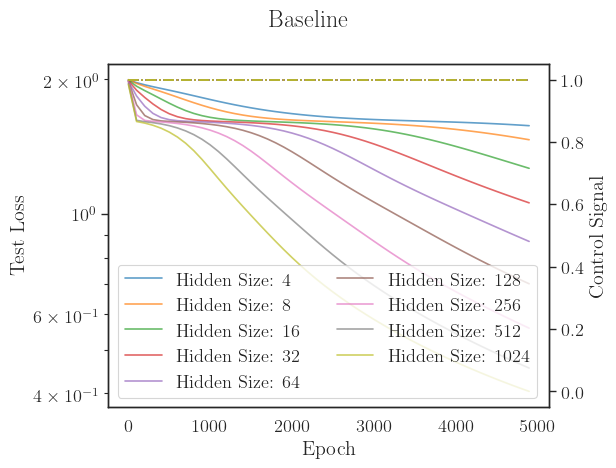

In [90]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_baseline["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_baseline["test_loss_mean"].values[i]
    #     - single_param_baseline["test_loss_std"].values[i],
    #     single_param_baseline["test_loss_mean"].values[i]
    #     + single_param_baseline["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
ax1.legend(loc="best", ncol=2)
# ax1.set_ylim(1e-6, 1)

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_baseline["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Baseline")
plt.tight_layout()

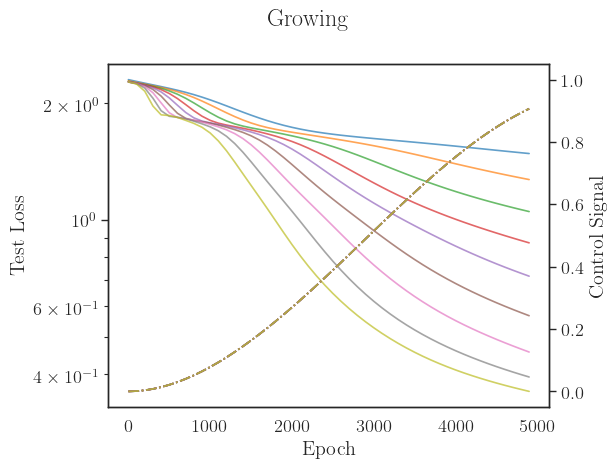

In [91]:
fig, ax1 = plt.subplots()

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_growing["test_loss_mean"].values[i],
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_growing["test_loss_mean"].values[i]
    #     - single_param_growing["test_loss_std"].values[i],
    #     single_param_growing["test_loss_mean"].values[i]
    #     + single_param_growing["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
# ax1.legend(loc="best")
# ax1.set_ylim(1e-6, 1)

# Create a second y-axis for the control signal
ax2 = ax1.twinx()
for i in range(len(hidden_sizes)):
    ax2.plot(
        epochs,
        single_param_growing["control_mean"].values[i],
        "-.",
        label=f"Hidden Size: {hidden_sizes[i]}",
        alpha=0.7,
    )

ax2.set_ylim(-0.05, 1.05)
ax2.set_ylabel("Control Signal")
# ax2.legend(loc="upper right")
plt.suptitle("Growing")
plt.tight_layout()

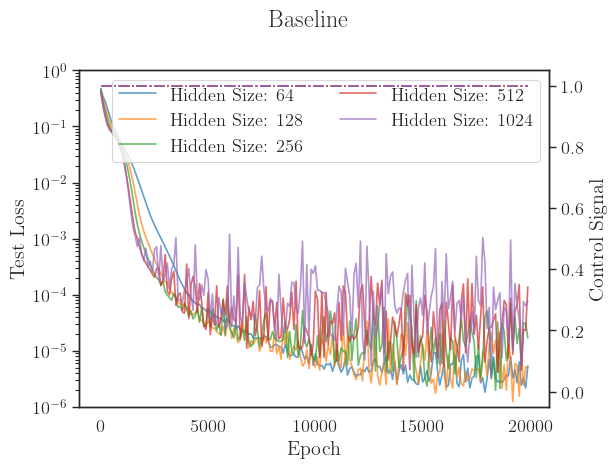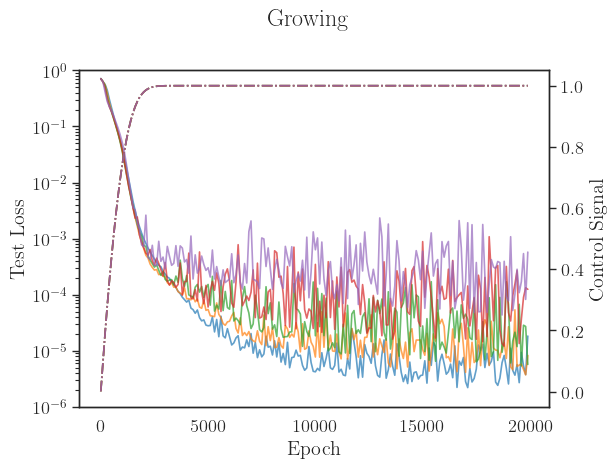

/tmp/ipykernel_370337/1211567928.py:72: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


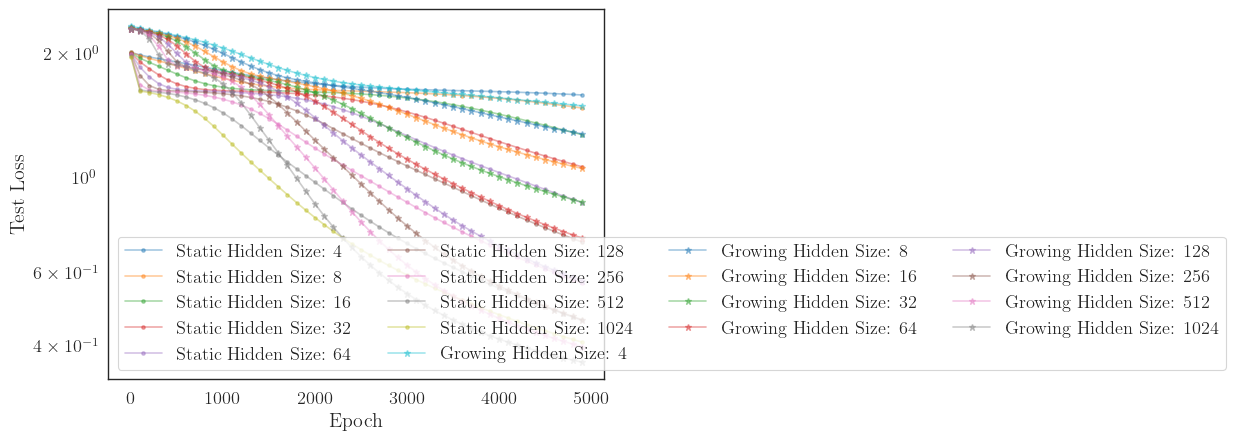

In [92]:
fig, ax1 = plt.subplots()
for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_baseline["test_loss_mean"].values[i],
        ".-",
        label=f"Static Hidden Size: {hidden_sizes[i]}",
        alpha=0.4,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_baseline["test_loss_mean"].values[i]
    #     - single_param_baseline["test_loss_std"].values[i],
    #     single_param_baseline["test_loss_mean"].values[i]
    #     + single_param_baseline["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
# ax1.legend(loc="best")
# ax1.set_ylim(1e-5, 1)

# # Create a second y-axis for the control signal
# ax2 = ax1.twinx()
# for i in range(len(hidden_sizes)):
#     ax2.plot(
#         epochs,
#         single_param_baseline["control_mean"].values[i],
#         "-.",
#         label=f"Hidden Size: {hidden_sizes[i]}",
#     )

for i in range(len(hidden_sizes)):
    ax1.plot(
        epochs,
        single_param_growing["test_loss_mean"].values[i],
        "*-",
        label=f"Growing Hidden Size: {hidden_sizes[i]}",
        alpha=0.4,
    )
    # ax1.fill_between(
    #     epochs,
    #     single_param_growing["test_loss_mean"].values[i]
    #     - single_param_growing["test_loss_std"].values[i],
    #     single_param_growing["test_loss_mean"].values[i]
    #     + single_param_growing["test_loss_std"].values[i],
    #     alpha=0.2,
    # )

ax1.set_ylabel("Test Loss")
ax1.set_yscale("log")
ax1.set_xlabel("Epoch")
# ax1.set_xscale("log")
ax1.legend(loc="best", ncol=4)
# ax1.set_ylim(1e-5, 1)

# # Create a second y-axis for the control signal
# ax2 = ax1.twinx()
# for i in range(len(hidden_sizes)):
#     ax2.plot(
#         epochs,
#         single_param_growing["control_mean"].values[i],
#         "-.",
#         label=f"Hidden Size: {hidden_sizes[i]}",
#         alpha=0.7,
#     )

ax2.set_ylim(-0.05, 1.05)
plt.tight_layout()

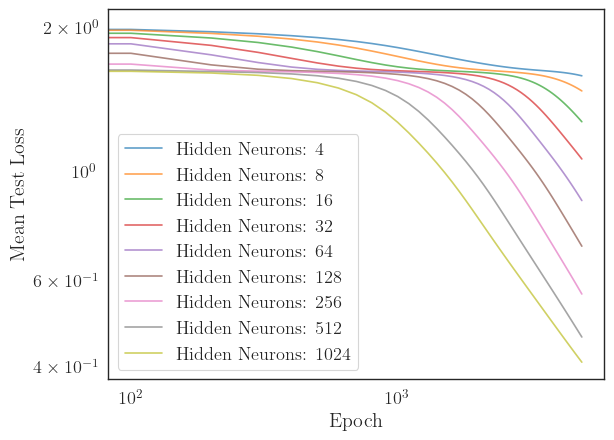

In [93]:
for i, loss in enumerate(single_param_baseline["test_loss_mean"].values):
    plt.plot(epochs, loss, label=f"Hidden Neurons: {hidden_sizes[i]}", alpha=0.7)
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Mean Test Loss")
plt.xscale("log")
plt.yscale("log")

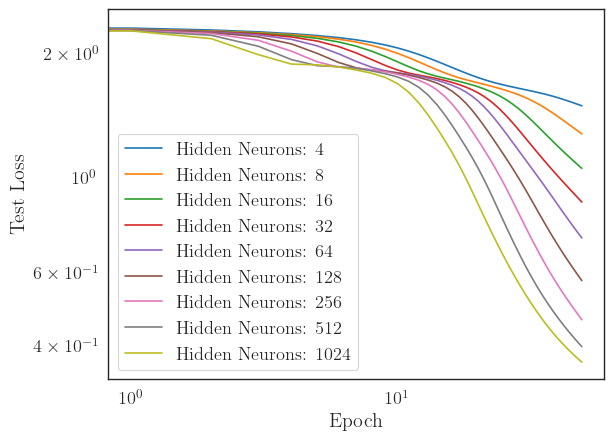

In [94]:
for i, loss in enumerate(single_param_growing["test_loss_mean"].values):
    plt.plot(loss, label=f"Hidden Neurons: {hidden_sizes[i]}")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Test Loss")
plt.xscale("log")
plt.yscale("log")

In [95]:
epochs[-1]

np.float64(4900.0)

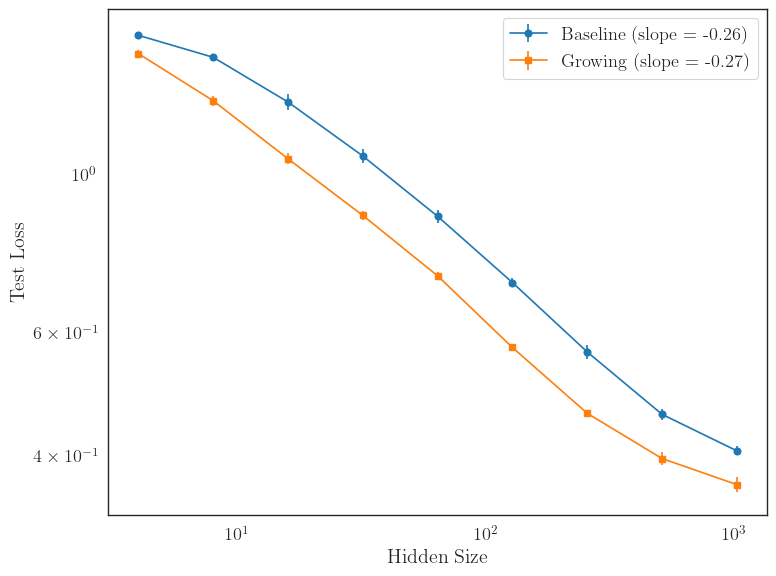

In [96]:
def extract_epoch_test_loss(df):
    return df["test_loss_mean"].apply(lambda x: x[-1]), df["test_loss_std"].apply(
        lambda x: x[-1]
    )


final_loss_baseline, final_loss_baseline_std = extract_epoch_test_loss(
    single_param_baseline
)
final_loss_growing, final_loss_growing_std = extract_epoch_test_loss(
    single_param_growing
)

# Get the hidden sizes associated with each run (they are the first level of the index)
hs_baseline = final_loss_baseline.index.get_level_values("hidden_size").astype(float)
hs_growing = final_loss_growing.index.get_level_values("hidden_size").astype(float)

# Fit a power law (linear fit in log–log coordinates) for each experiment
log_hs_baseline = np.log(hs_baseline)
log_loss_baseline = np.log(final_loss_baseline)
slope_baseline, intercept_baseline = np.polyfit(log_hs_baseline, log_loss_baseline, 1)

log_hs_growing = np.log(hs_growing)
log_loss_growing = np.log(final_loss_growing)
slope_growing, intercept_growing = np.polyfit(log_hs_growing, log_loss_growing, 1)

# Plot the scaling laws with error bars
plt.figure(figsize=(8, 6))
plt.errorbar(
    hs_baseline,
    final_loss_baseline,
    yerr=final_loss_baseline_std,
    fmt="o-",
    label=f"Baseline (slope = {slope_baseline:.2f})",
)
plt.errorbar(
    hs_growing,
    final_loss_growing,
    yerr=final_loss_growing_std,
    fmt="s-",
    label=f"Growing (slope = {slope_growing:.2f})",
)
plt.xlabel("Hidden Size")
plt.ylabel("Test Loss")
# plt.ylim(1e-5, 1e-2)
plt.xscale("log")
plt.yscale("log")
# plt.title("Scaling Law: Test Loss vs Hidden Size")
plt.legend()
plt.tight_layout()
plt.savefig(
    fig_dir + f"classification_scaling_loss_hidden_{lr}_{n_classes}_{epochs[-1]}.pdf"
)
plt.savefig(
    fig_dir + f"classification_scaling_loss_hidden_{lr}_{n_classes}_{epochs[-1]}.svg"
)
plt.savefig(
    fig_dir + f"classification_scaling_loss_hidden_{lr}_{n_classes}_{epochs[-1]}.png"
)